### Step 1: Import Necessary Libraries

In [17]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Step 2: Load and Inspect the Dataset
Load the dataset and display the first few rows to understand its structure.

In [18]:
# Step 2: Load and inspect the dataset
data = pd.read_csv("Earthquake_data_processed.csv")  # Replace with the path to your dataset
data.head()  # View the first few rows


,Unnamed: 0,Date(YYYY/MM/DD),Time(UTC),Latitude(deg),Longitude(deg),Depth(km),Magnitude(ergs),Magnitude_type,No_of_Stations,Gap,Close,RMS,SRC,EventID
0,0,1966/07/01,09:41:21.82,35.9463,-120.4700,12.26,3.2,Mx,7,171,20,0.02,NCSN,-4540462
1,1,1966/07/02,12:08:34.25,35.7867,-120.3265,8.99,3.7,Mx,8,86,3,0.04,NCSN,-4540520
2,2,1966/07/02,12:16:14.95,35.7928,-120.3353,9.88,3.4,Mx,8,89,2,0.03,NCSN,-4540521
3,3,1966/07/02,12:25:06.12,35.7970,-120.3282,9.09,3.1,Mx,8,101,3,0.08,NCSN,-4540522
4,4,1966/07/05,18:54:54.36,35.9223,-120.4585,7.86,3.1,Mx,9,161,14,0.04,NCSN,-4540594


### Step 3: Combine Date and Time Columns into a Single Datetime Column
This merges the date and time into a single Timestamp column and sets it as the index.

In [19]:
# Step 3: Convert Date and Time to a single datetime column
data['Timestamp'] = pd.to_datetime(data['Date(YYYY/MM/DD)'] + ' ' + data['Time(UTC)'], errors='coerce')
data.set_index('Timestamp', inplace=True)
data = data.drop(columns=['Date(YYYY/MM/DD)', 'Time(UTC)'])


### Step 4: Feature Engineering with Time and Additional Columns
Add new features based on the timestamp, such as the day of the week and hour of the day.

In [20]:
# Step 4: Feature Engineering with time and additional columns
data['DayOfWeek'] = data.index.dayofweek  # Day of the week as an integer (0=Monday, 6=Sunday)
data['Hour'] = data.index.hour  # Hour of the day


### Step 5: Encode Categorical Variables and Ensure Correct Data Types
Convert categorical variables into dummy variables and ensure all relevant columns are in the correct data type for modeling.

In [21]:
# Step 5: Encoding categorical variables if necessary
data = pd.get_dummies(data, columns=['SRC', 'Magnitude_type'], drop_first=True)

# Select relevant features and convert to float if necessary
data['No_of_Stations'] = data['No_of_Stations'].astype(float)
data['Gap'] = data['Gap'].astype(float)
data['Close'] = data['Close'].astype(float)
data['RMS'] = data['RMS'].astype(float)


### Step 6: Create Target Variable 'Earthquake_Predicted'
Define the target variable based on whether another earthquake is expected within a specified time window.

In [22]:
# Step 6: Create the target variable: 'Earthquake_Predicted'
time_window = timedelta(hours=6)  # Adjust as needed
data['Earthquake_Predicted'] = (data.index.to_series().diff(-1).abs() <= time_window).astype(int)


### Step 7: Split the Data into Features and Target
Separate the data into feature variables (X) and the target variable (y).

In [23]:
# Step 7: Split the data into features and target
X = data[['Latitude(deg)', 'Longitude(deg)', 'Depth(km)', 'Magnitude(ergs)', 'No_of_Stations', 'Gap', 'Close', 'RMS', 'DayOfWeek', 'Hour']]
y = data['Earthquake_Predicted']


### Step 8: Split the Data into Training and Testing Sets
Split the data for training (70%) and testing (30%).

In [24]:
# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Step 9: Train the Model Using Random Forest Classifier
Train a Random Forest model on the training data.

In [25]:
# Step 9: Model Training with Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

### Step 10: Evaluate the Model
Make predictions on the test set and calculate the accuracy, along with other evaluation metrics.

In [26]:
# Step 10: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Model Accuracy: 0.6589018302828619
              precision    recall  f1-score   support

           0       0.66      0.77      0.71      2963
           1       0.66      0.52      0.58      2446

    accuracy                           0.66      5409
   macro avg       0.66      0.65      0.65      5409
weighted avg       0.66      0.66      0.65      5409



### Step 11: Visualize the Confusion Matrix
Display a confusion matrix to better understand the model’s performance.

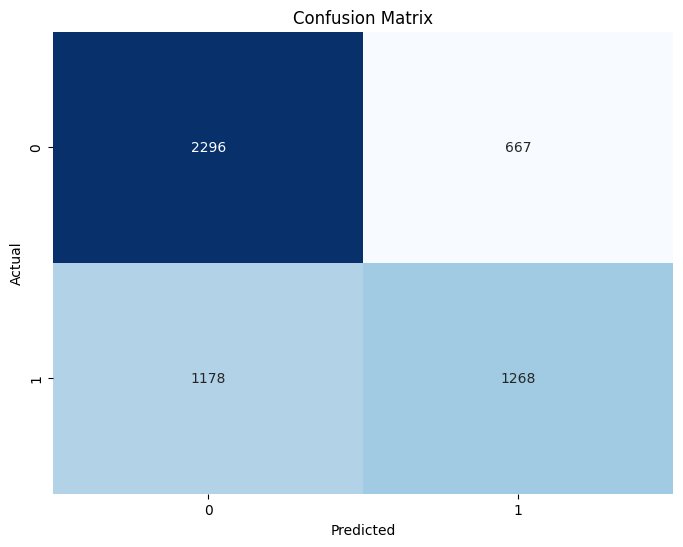

In [27]:
# Step 11: Visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Step 12: Interactive Map Visualization with Plotly
Plot the earthquake locations on an interactive map, showing their magnitude and depth.

In [28]:
fig = px.scatter_mapbox(data, lat="Latitude(deg)", lon="Longitude(deg)", color="Magnitude(ergs)",
                        size="Depth(km)", zoom=5, mapbox_style="carto-positron", 
                        title="Earthquake Locations by Magnitude")
fig.update_layout(mapbox_style="open-street-map", height=600)
fig.show(renderer="browser")



### Step 13: Distribution of Magnitude and Depth
Visualize the distributions of earthquake magnitudes and depths using histograms.

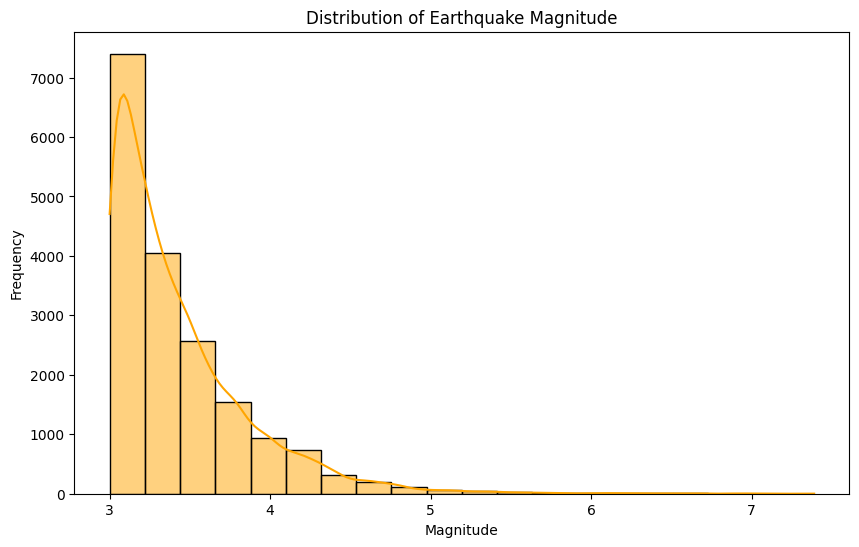

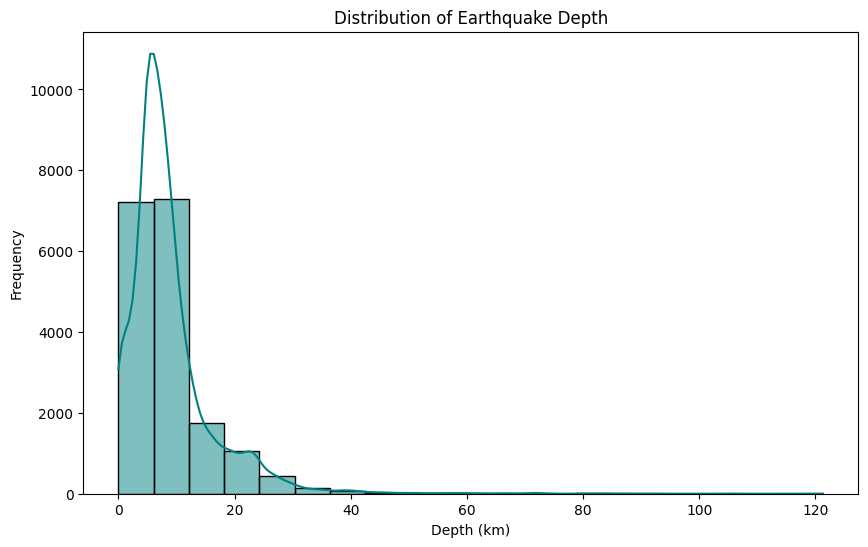

In [29]:
# Step 13: Distribution of Magnitude and Depth using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data['Magnitude(ergs)'], bins=20, kde=True, color='orange')
plt.title("Distribution of Earthquake Magnitude")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['Depth(km)'], bins=20, kde=True, color='teal')
plt.title("Distribution of Earthquake Depth")
plt.xlabel("Depth (km)")
plt.ylabel("Frequency")
plt.show()


### Step 14: Define Prediction Function
Define a function that allows you to input specific details of an earthquake event and predict whether an earthquake is likely.

In [30]:
# Step 14: Function to Predict Earthquake Risk for Given Input
def predict_earthquake(date, time, latitude, longitude, depth, magnitude, no_of_stations, gap, close, rms):
    timestamp = pd.to_datetime(date + ' ' + time)
    day_of_week = timestamp.dayofweek
    hour = timestamp.hour

    input_data = pd.DataFrame([[latitude, longitude, depth, magnitude, no_of_stations, gap, close, rms, day_of_week, hour]],
                              columns=['Latitude(deg)', 'Longitude(deg)', 'Depth(km)', 'Magnitude(ergs)', 
                                       'No_of_Stations', 'Gap', 'Close', 'RMS', 'DayOfWeek', 'Hour'])
    
    prediction = model.predict(input_data)
    if prediction[0] == 1:
        print("Warning: High likelihood of earthquake!")
    else:
        print("No significant earthquake expected.")


### Step 15: Example Prediction
Test the function with an example earthquake event to see if the model predicts a likely occurrence.

In [31]:
# Step 15: Example Prediction
predict_earthquake('1966/08/19', '22:51:20', 35.914, -120.4272, 1.67, 3.3, 6, 165, 11, 0.1)


No significant earthquake expected.


In [32]:
# Import necessary libraries
import tkinter as tk
from tkinter import messagebox

# Step 15: Function to predict earthquake risk based on user input
def predict_earthquake_from_date():
    # Get user input from the entry box
    date = entry_date.get()
    
    # Default values for the other parameters
    time = "00:00:00"       # Default time (midnight)
    latitude = 35.0         # Example default latitude
    longitude = -120.0      # Example default longitude
    depth = 10.0            # Example depth
    magnitude = 4.0         # Example magnitude
    no_of_stations = 10     # Example number of stations
    gap = 180               # Example azimuthal gap
    close = 20              # Example distance to closest station
    rms = 0.1               # Example RMS value
    
    try:
        # Prepare timestamp for day of week and hour extraction
        timestamp = pd.to_datetime(date + ' ' + time)
        day_of_week = timestamp.dayofweek
        hour = timestamp.hour

        # Prepare input data in the format expected by the model
        input_data = pd.DataFrame([[latitude, longitude, depth, magnitude, no_of_stations, gap, close, rms, day_of_week, hour]],
                                  columns=['Latitude(deg)', 'Longitude(deg)', 'Depth(km)', 'Magnitude(ergs)', 
                                           'No_of_Stations', 'Gap', 'Close', 'RMS', 'DayOfWeek', 'Hour'])
        
        # Predict earthquake occurrence using the model
        prediction = model.predict(input_data)
        
        # Display prediction result
        if prediction[0] == 1:
            messagebox.showinfo("Prediction", "Warning: High likelihood of earthquake!")
        else:
            messagebox.showinfo("Prediction", "No significant earthquake expected.")
    except Exception as e:
        messagebox.showerror("Error", f"Invalid date format: {e}")

# Create a simple GUI for input
root = tk.Tk()
root.title("Earthquake Prediction")
root.geometry("300x150")

# Label and Entry for Date Input
label_date = tk.Label(root, text="Enter Date (YYYY/MM/DD):")
label_date.pack(pady=5)
entry_date = tk.Entry(root, width=20)
entry_date.pack(pady=5)

# Predict Button
button_predict = tk.Button(root, text="Predict Earthquake", command=predict_earthquake_from_date)
button_predict.pack(pady=10)

# Run the GUI loop
root.mainloop()


### Step 16: Save and Deploy the Earthquake Prediction Model
This step involves saving the trained model to disk and preparing it for deployment in a production environment. We can use joblib or pickle to save the model, making it easy to load later for predictions, either in this script or in a separate application.

In [33]:
# Import necessary libraries
import joblib

# Save the trained model to disk
model_filename = 'earthquake_prediction_model.joblib'
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")

# Example of how to load the model
# loaded_model = joblib.load(model_filename)
# This loaded model can be used for predictions just like the original model

# Save the feature names/column order to ensure consistent predictions
feature_columns = ['Latitude(deg)', 'Longitude(deg)', 'Depth(km)', 'Magnitude(ergs)', 
                  'No_of_Stations', 'Gap', 'Close', 'RMS', 'DayOfWeek', 'Hour']
joblib.dump(feature_columns, 'feature_columns.joblib')
print("Feature columns saved")

# Note: When deploying, ensure both model and feature_columns files are included
# and the required libraries (scikit-learn, pandas, etc.) are installed


Model saved as earthquake_prediction_model.joblib
Feature columns saved


In [34]:
def predict_and_visualize():
    try:
        # Get date and time from input fields
        date_str = entry_date.get()
        time_str = entry_time.get()
        timestamp = pd.to_datetime(f"{date_str} {time_str}")
        day_of_week = timestamp.dayofweek
        hour = timestamp.hour

        # Create a grid of points across the map region
        lat_range = np.linspace(data['Latitude(deg)'].min(), data['Latitude(deg)'].max(), 20)
        lon_range = np.linspace(data['Longitude(deg)'].min(), data['Longitude(deg)'].max(), 20)
        
        predictions = []
        
        # Calculate average values for parameters
        avg_stations = data['No_of_Stations'].mean()
        avg_gap = data['Gap'].mean()
        avg_close = data['Close'].mean()
        avg_rms = data['RMS'].mean()

        # Calculate predictions for each point
        for lat in lat_range:
            for lon in lon_range:
                # Get historical earthquakes near this point
                radius = 0.5  # degrees (~55km)
                mask = ((data['Latitude(deg)'] - lat).abs() <= radius) & ((data['Longitude(deg)'] - lon).abs() <= radius)
                local_data = data[mask]
                
                if len(local_data) > 0:
                    # Use local average depth and magnitude if data exists
                    depth = local_data['Depth(km)'].mean()
                    magnitude = local_data['Magnitude(ergs)'].mean()
                else:
                    # Fallback to global averages
                    depth = data['Depth(km)'].mean()
                    magnitude = data['Magnitude(ergs)'].mean()

                input_data = pd.DataFrame([[lat, lon, depth, magnitude, 
                                          avg_stations, avg_gap, avg_close, avg_rms, 
                                          day_of_week, hour]],
                                        columns=['Latitude(deg)', 'Longitude(deg)', 'Depth(km)', 
                                                'Magnitude(ergs)', 'No_of_Stations', 'Gap', 
                                                'Close', 'RMS', 'DayOfWeek', 'Hour'])
                
                prediction = model.predict_proba(input_data)[0][1]  # Get probability
                
                # Estimate magnitude based on historical patterns and prediction confidence
                if prediction > 0.5:  # If high probability of earthquake
                    # Use local maximum magnitude with some variation based on prediction
                    estimated_magnitude = (local_data['Magnitude(ergs)'].max() * prediction 
                                         if len(local_data) > 0 else magnitude * prediction)
                    predictions.append((lat, lon, estimated_magnitude))

        # Create map visualization
        fig = go.Figure()

        # Add historical earthquakes as background
        fig.add_trace(go.Scattermapbox(
            lat=data['Latitude(deg)'],
            lon=data['Longitude(deg)'],
            mode='markers',
            marker=dict(
                size=5,
                color=data['Magnitude(ergs)'],
                colorscale='Viridis',
                opacity=0.3
            ),
            name='Historical Events'
        ))

        if predictions:  # Only if we have predictions
            # Add prediction points
            lats, lons, mags = zip(*predictions)
            fig.add_trace(go.Scattermapbox(
                lat=lats,
                lon=lons,
                mode='markers',
                marker=dict(
                    size=12,
                    color=mags,
                    colorscale='Reds',
                    opacity=0.8,
                    colorbar=dict(title="Expected Magnitude"),
                    cmin=min(data['Magnitude(ergs)']),
                    cmax=max(data['Magnitude(ergs)'])
                ),
                text=[f"Expected Magnitude: {m:.1f}" for m in mags],
                name='Predicted Events'
            ))

            # Calculate center point for map
            center_lat = (max(lats) + min(lats)) / 2
            center_lon = (max(lons) + min(lons)) / 2
        else:
            # Use center of historical data if no predictions
            center_lat = data['Latitude(deg)'].mean()
            center_lon = data['Longitude(deg)'].mean()

        fig.update_layout(
            mapbox_style="open-street-map",
            mapbox=dict(
                center=dict(lat=center_lat, lon=center_lon),
                zoom=5
            ),
            height=800,
            title=f"Expected Earthquakes for {timestamp.strftime('%Y-%m-%d %H:%M')}"
        )
        
        fig.show(renderer="browser")
        
    except Exception as e:
        messagebox.showerror("Error", f"Invalid input: {str(e)}")

# Create GUI window
prediction_window = tk.Tk()
prediction_window.title("Earthquake Prediction Map")
prediction_window.geometry("300x200")

# Create date and time input fields
ttk.Label(prediction_window, text="Date (YYYY/MM/DD):").pack(pady=5)
entry_date = ttk.Entry(prediction_window)
entry_date.insert(0, datetime.now().strftime('%Y/%m/%d'))  # Default to current date
entry_date.pack()

ttk.Label(prediction_window, text="Time (HH:MM:SS):").pack(pady=5)
entry_time = ttk.Entry(prediction_window)
entry_time.insert(0, datetime.now().strftime('%H:%M:%S'))  # Default to current time
entry_time.pack()

# Add predict button
ttk.Button(prediction_window, text="Show Prediction Map", 
           command=predict_and_visualize).pack(pady=20)

# Run the window
prediction_window.mainloop()

In [35]:
import tkinter as tk
from tkinter import ttk, messagebox
from tkcalendar import DateEntry
from datetime import datetime
import customtkinter as ctk
import pandas as pd
import numpy as np
import plotly.graph_objects as go

class EarthquakePredictionApp:
    def __init__(self):
        # Set theme and color scheme
        ctk.set_appearance_mode("dark")
        ctk.set_default_color_theme("blue")
        
        # Create main window
        self.root = ctk.CTk()
        self.root.title("Earthquake Prediction System")
        self.root.geometry("1000x800")
        
        # Create main containers
        self.create_header_frame()
        self.create_input_frame()
        self.create_map_options_frame()
        self.create_status_frame()
        
    def create_header_frame(self):
        header_frame = ctk.CTkFrame(self.root)
        header_frame.pack(fill="x", padx=20, pady=10)
        
        title_label = ctk.CTkLabel(
            header_frame, 
            text="Earthquake Prediction System",
            font=("Helvetica", 32, "bold")
        )
        title_label.pack(pady=10)
        
        desc_label = ctk.CTkLabel(
            header_frame,
            text="Enter date and time to visualize earthquake predictions",
            font=("Helvetica", 16)
        )
        desc_label.pack(pady=5)
        
    def create_input_frame(self):
        input_frame = ctk.CTkFrame(self.root)
        input_frame.pack(fill="x", padx=40, pady=20)
        
        # Date input section
        date_frame = ctk.CTkFrame(input_frame)
        date_frame.pack(fill="x", pady=15)
        
        date_label = ctk.CTkLabel(
            date_frame, 
            text="Date:",
            font=("Helvetica", 18)
        )
        date_label.pack(side="left", padx=20)
        
        self.date_entry = DateEntry(
            date_frame,
            width=15,
            height=40,
            font=("Helvetica", 16),
            background='darkblue',
            foreground='white',
            borderwidth=2,
            date_pattern='yyyy/mm/dd'
        )
        self.date_entry.pack(side="left", padx=20, pady=10)
        
        # Time input section
        time_frame = ctk.CTkFrame(input_frame)
        time_frame.pack(fill="x", pady=15)
        
        time_label = ctk.CTkLabel(
            time_frame, 
            text="Time:",
            font=("Helvetica", 18)
        )
        time_label.pack(side="left", padx=20)
        
        time_spinboxes_frame = ctk.CTkFrame(time_frame)
        time_spinboxes_frame.pack(side="left", padx=20)
        
        # Hour spinbox
        self.hour_spinbox = ttk.Spinbox(
            time_spinboxes_frame,
            from_=0,
            to=23,
            width=3,
            format="%02.0f",
            font=("Helvetica", 16),
            command=lambda: self.validate_spinbox(self.hour_spinbox, 0, 23)
        )
        self.hour_spinbox.set("00")
        self.hour_spinbox.pack(side="left", padx=5)
        
        ctk.CTkLabel(
            time_spinboxes_frame, 
            text=":",
            font=("Helvetica", 20, "bold")
        ).pack(side="left")
        
        # Minute spinbox
        self.min_spinbox = ttk.Spinbox(
            time_spinboxes_frame,
            from_=0,
            to=59,
            width=3,
            format="%02.0f",
            font=("Helvetica", 16),
            command=lambda: self.validate_spinbox(self.min_spinbox, 0, 59)
        )
        self.min_spinbox.set("00")
        self.min_spinbox.pack(side="left", padx=5)
        
        ctk.CTkLabel(
            time_spinboxes_frame, 
            text=":",
            font=("Helvetica", 20, "bold")
        ).pack(side="left")
        
        # Second spinbox
        self.sec_spinbox = ttk.Spinbox(
            time_spinboxes_frame,
            from_=0,
            to=59,
            width=3,
            format="%02.0f",
            font=("Helvetica", 16),
            command=lambda: self.validate_spinbox(self.sec_spinbox, 0, 59)
        )
        self.sec_spinbox.set("00")
        self.sec_spinbox.pack(side="left", padx=5)
        
    def create_map_options_frame(self):
        options_frame = ctk.CTkFrame(self.root)
        options_frame.pack(fill="x", padx=40, pady=20)
        
        style_label = ctk.CTkLabel(
            options_frame, 
            text="Map Style:",
            font=("Helvetica", 16)
        )
        style_label.pack(pady=10)
        
        self.map_style = ctk.CTkOptionMenu(
            options_frame,
            values=["open-street-map", "carto-positron", "carto-darkmatter", "stamen-terrain"],
            command=self.on_map_style_change,
            font=("Helvetica", 14)
        )
        self.map_style.pack(pady=5)
        
        threshold_label = ctk.CTkLabel(
            options_frame, 
            text="Prediction Threshold:",
            font=("Helvetica", 16)
        )
        threshold_label.pack(pady=10)
        
        self.threshold_slider = ctk.CTkSlider(
            options_frame,
            from_=0,
            to=1,
            number_of_steps=20,
            command=self.on_threshold_change,
            width=300
        )
        self.threshold_slider.pack(pady=5)
        
        self.threshold_label = ctk.CTkLabel(
            options_frame, 
            text="0.5",
            font=("Helvetica", 14)
        )
        self.threshold_label.pack()
        
        self.predict_button = ctk.CTkButton(
            options_frame,
            text="Generate Prediction Map",
            command=self.predict_and_visualize,
            font=("Helvetica", 16, "bold"),
            height=40
        )
        self.predict_button.pack(pady=20)
        
    def create_status_frame(self):
        self.status_frame = ctk.CTkFrame(self.root)
        self.status_frame.pack(fill="x", padx=40, pady=20)
        
        self.status_label = ctk.CTkLabel(
            self.status_frame,
            text="Ready to generate predictions...",
            font=("Helvetica", 14)
        )
        self.status_label.pack(pady=10)
        
        self.progress_bar = ctk.CTkProgressBar(
            self.status_frame,
            width=400
        )
        self.progress_bar.pack(pady=10)
        self.progress_bar.set(0)
        
    def validate_spinbox(self, spinbox, min_val, max_val):
        try:
            value = int(spinbox.get())
            if value < min_val:
                spinbox.set(f"{min_val:02d}")
            elif value > max_val:
                spinbox.set(f"{max_val:02d}")
            else:
                spinbox.set(f"{value:02d}")
        except ValueError:
            spinbox.set("00")
            
    def on_map_style_change(self, choice):
        self.map_style_value = choice
        
    def on_threshold_change(self, value):
        self.threshold_label.configure(text=f"{value:.2f}")
        self.threshold_value = value
        
    def predict_and_visualize(self):
        try:
            # Get date and time from input fields
            date_str = self.date_entry.get()
            hour = self.hour_spinbox.get().zfill(2)
            minute = self.min_spinbox.get().zfill(2)
            second = self.sec_spinbox.get().zfill(2)
            time_str = f"{hour}:{minute}:{second}"

            # Combine date and time
            timestamp = pd.to_datetime(f"{date_str} {time_str}")
            day_of_week = timestamp.dayofweek
            hour = timestamp.hour

            self.status_label.configure(text="Generating predictions...")
            self.progress_bar.start()

            # Create a grid of points across the map region
            lat_range = np.linspace(data['Latitude(deg)'].min(), data['Latitude(deg)'].max(), 20)
            lon_range = np.linspace(data['Longitude(deg)'].min(), data['Longitude(deg)'].max(), 20)
            
            predictions = []
            
            # Calculate average values for parameters
            avg_stations = data['No_of_Stations'].mean()
            avg_gap = data['Gap'].mean()
            avg_close = data['Close'].mean()
            avg_rms = data['RMS'].mean()

            # Calculate predictions for each point
            for lat in lat_range:
                for lon in lon_range:
                    radius = 0.5
                    mask = ((data['Latitude(deg)'] - lat).abs() <= radius) & ((data['Longitude(deg)'] - lon).abs() <= radius)
                    local_data = data[mask]
                    
                    if len(local_data) > 0:
                        depth = local_data['Depth(km)'].mean()
                        magnitude = local_data['Magnitude(ergs)'].mean()
                    else:
                        depth = data['Depth(km)'].mean()
                        magnitude = data['Magnitude(ergs)'].mean()

                    input_data = pd.DataFrame([[lat, lon, depth, magnitude, 
                                              avg_stations, avg_gap, avg_close, avg_rms, 
                                              day_of_week, hour]],
                                            columns=['Latitude(deg)', 'Longitude(deg)', 'Depth(km)', 
                                                    'Magnitude(ergs)', 'No_of_Stations', 'Gap', 
                                                    'Close', 'RMS', 'DayOfWeek', 'Hour'])
                    
                    prediction = model.predict_proba(input_data)[0][1]
                    
                    if prediction > self.threshold_value:
                        estimated_magnitude = (local_data['Magnitude(ergs)'].max() * prediction 
                                             if len(local_data) > 0 else magnitude * prediction)
                        predictions.append((lat, lon, estimated_magnitude))

            # Create map visualization
            fig = go.Figure()

            # Add historical earthquakes as background
            fig.add_trace(go.Scattermapbox(
                lat=data['Latitude(deg)'],
                lon=data['Longitude(deg)'],
                mode='markers',
                marker=dict(
                    size=5,
                    color=data['Magnitude(ergs)'],
                    colorscale='Viridis',
                    opacity=0.3
                ),
                name='Historical Events'
            ))

            if predictions:
                lats, lons, mags = zip(*predictions)
                fig.add_trace(go.Scattermapbox(
                    lat=lats,
                    lon=lons,
                    mode='markers',
                    marker=dict(
                        size=12,
                        color=mags,
                        colorscale='Reds',
                        opacity=0.8,
                        colorbar=dict(title="Expected Magnitude"),
                        cmin=min(data['Magnitude(ergs)']),
                        cmax=max(data['Magnitude(ergs)'])
                    ),
                    text=[f"Expected Magnitude: {m:.1f}" for m in mags],
                    name='Predicted Events'
                ))

                center_lat = (max(lats) + min(lats)) / 2
                center_lon = (max(lons) + min(lons)) / 2
            else:
                center_lat = data['Latitude(deg)'].mean()
                center_lon = data['Longitude(deg)'].mean()

            fig.update_layout(
                mapbox_style=self.map_style_value,
                mapbox=dict(
                    center=dict(lat=center_lat, lon=center_lon),
                    zoom=5
                ),
                height=800,
                title=f"Expected Earthquakes for {timestamp.strftime('%Y-%m-%d %H:%M')}"
            )
            
            fig.show(renderer="browser")
            
            self.status_label.configure(text="Prediction map generated successfully!")
            self.progress_bar.stop()
            self.progress_bar.set(1)
            
        except Exception as e:
            self.status_label.configure(text=f"Error: {str(e)}")
            self.progress_bar.stop()
            self.progress_bar.set(0)
            messagebox.showerror("Error", str(e))
            
    def run(self):
        # Initialize default values
        self.map_style_value = "open-street-map"
        self.threshold_value = 0.5
        self.threshold_slider.set(0.5)
        
        # Start the application
        self.root.mainloop()

# Create and run the application
if __name__ == "__main__":
    app = EarthquakePredictionApp()
    app.run()